# Programa de ML para TURBIDEZ

A continuación, se encuentra el paso a paso y código utilizado en la modelación de ML de la `Turbidez` en la bahía de cartagena a partir de datos de teledetección, los puntos relevantes tratados aquí son:

- Análisis de anomalías
- División del conjunto de datos
- Construcción de los algoritmos de ML (Lineal, SVM, DT y RF)
- Modelación del parámetro de calidad de agua a partir del método seleccionado


`Por Mercado A. & Mercado M. (2024)`

## Importación de Librerías

In [39]:
#Limpieza de la terminal por cada ejecución del código
import os
os.system('cls' if os.name == 'nt' else 'clear')


0

In [40]:
#Librerías necesarias para el tratamiento de datos
import pandas as pd
import numpy as np

#Librerías necesarias para ML
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV

#Librerías para calculo de error
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_percentage_error

#Librerias para graficos y anomalías
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.gridspec as gridspec
from collections import Counter
from sklearn import metrics
import numpy as np
from matplotlib.colors import LogNorm
from sklearn.metrics import f1_score
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor

In [41]:
#Lectura del dataset
dataset = './DATASET-TT./MAYOR-166-TT.xlsx'
df_turb = pd.read_excel(dataset)

#Para transformar el tipo de dato de las columnas con bandas en float
bandas = df_turb.columns[13:30].tolist()
df_turb[bandas] = df_turb[bandas].astype(float)

valor_para_X = input('Por favor, seleccione una banda -- >  ') #Nombre  de la columna (tal cual) de la base de datos que representa la banda/combinatoria/índice a utilizar

#Se tabulan los datos de forma preliminar
df_turb = df_turb[[ valor_para_X , 'Valor']]

df_turb = df_turb.dropna()

df_turb

,Rrs_665,Valor
0,0.003030,1.37
1,0.002100,1.54
2,0.002442,1.61
3,0.003654,1.61
4,0.003665,1.66
...,...,...
161,0.028155,187.00
162,0.027228,194.00
163,0.027280,203.00
164,0.024797,212.00


## Análisis de anomalías

### Elliptic Envelope `Genera el dataframe Xy_COV`

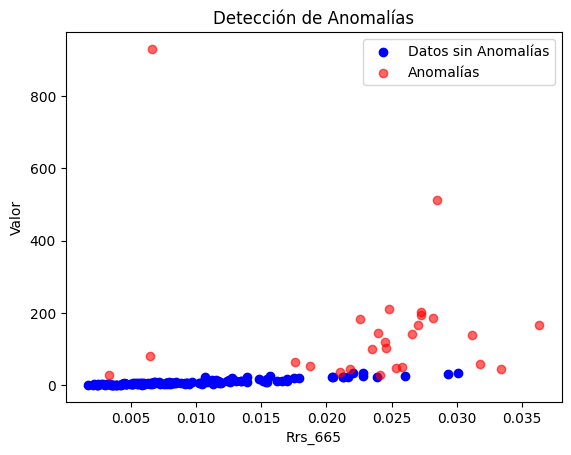

In [42]:
# Modelo Detector de Anomalías por Covarianza
detector_covariance = EllipticEnvelope(contamination=0.15)  # Ajusta contamination según la proporción esperada de anomalías
detector_covariance.fit(df_turb[[ valor_para_X , 'Valor']])  # X es tu conjunto de datos, con la característica x

# Identificar anomalías usando el modelo Detector de Anomalías por Covarianza
anomalies_covariance = detector_covariance.predict(df_turb[[ valor_para_X , 'Valor']]) == -1

# Modelo Detección de Anomalías por los Vecinos Más Cercanos
detector_lof = LocalOutlierFactor(n_neighbors=30, contamination=0.15)  # Ajusta n_neighbors y contamination según tus datos
anomalies_lof = detector_lof.fit_predict(df_turb[[ valor_para_X , 'Valor']]) == -1

# Combinar los resultados de ambos modelos
anomalies_combined = anomalies_covariance | anomalies_lof

# Eliminar los valores anómalos del DataFrame original
clean_df = df_turb[~anomalies_combined]

Xy_COV= clean_df
Xy_COV

# Graficar el DataFrame resultante

# Graficar los puntos sin anomalías
plt.scatter(Xy_COV[valor_para_X], Xy_COV['Valor'], color='blue', label='Datos sin Anomalías')

# Opcional: Graficar los puntos detectados como anomalías
plt.scatter(df_turb.loc[anomalies_combined, valor_para_X], df_turb.loc[anomalies_combined, 'Valor'], color='red', label='Anomalías', alpha=0.6)

plt.xlabel(valor_para_X)
plt.ylabel('Valor')
plt.legend()
plt.title('Detección de Anomalías')
plt.show()

## División del conjunto de datos

### Train-Test Split

In [43]:
#Dataset split
DF = input("¿Qué dataframe deseas utilizar? (df_turb OR Xy_COV)")
print(f'DF:{DF}')
train_set, test_set = train_test_split(globals()[DF], test_size=0.2, random_state=42) #Ajuste el test_size según sus necesidades

#Train set
print('*'*30)
print('Train-set info')
print(train_set.info())

#Test set
print('*'*30)
print('Test-set info')
print(test_set.info())


DF:Xy_COV
******************************
Train-set info
<class 'pandas.core.frame.DataFrame'>
Index: 112 entries, 16 to 102
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Rrs_665  112 non-null    float64
 1   Valor    112 non-null    float64
dtypes: float64(2)
memory usage: 2.6 KB
None
******************************
Test-set info
<class 'pandas.core.frame.DataFrame'>
Index: 28 entries, 108 to 96
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Rrs_665  28 non-null     float64
 1   Valor    28 non-null     float64
dtypes: float64(2)
memory usage: 672.0 bytes
None


### Visualización del conjunto de datos de entrenamiento

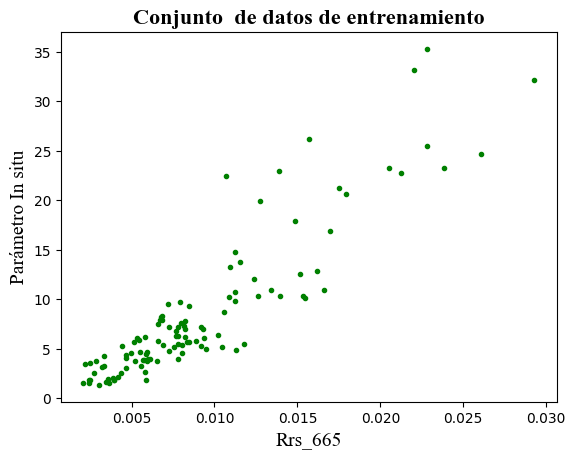

In [44]:
#Variables
#Train
x = train_set[valor_para_X]
y = train_set['Valor']

#Test
x_test = test_set[valor_para_X]
y_test = test_set['Valor']

#Visualizacion de los datos
plt.plot(x, y, "g.")
#plt.xlim(0, 0.03)
#plt.ylim(0, 100)
plt.xlabel(valor_para_X, fontdict={'family': 'Times New Roman', 'size': 14})
plt.ylabel("Parámetro In situ", fontdict={'family': 'Times New Roman', 'size': 14})
plt.title(f'Conjunto  de datos de entrenamiento', fontname='Times New Roman', fontsize=16, fontweight='bold')
plt.show()

## Algoritmos de Machine Learning

### Funciones y declaraciones comunes entre métodos de ML

In [45]:
#Función para convertir MAPE en un valor porcentual
def mean_absolute_percentage_error_perc(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred) * 100

#Funciones de puntuación personalizadas para R2, MSE Y MAPE, usadas en la cross-valitation (CV)
r2_scorer = make_scorer(r2_score)
mse_scorer = make_scorer(mean_squared_error)
mape_scorer_perc = make_scorer(mean_absolute_percentage_error_perc)

#Scoring para el ajuste de hiper-parámetros
scoring_gs = {'r2': 'r2', 'mse': 'neg_mean_squared_error', 'mape': 'neg_mean_absolute_percentage_error'}
#Scoring para CV luego del ajuste de hiper-parámetros
scoring = {'r2': r2_scorer, 'mse': mse_scorer, 'mape': mape_scorer_perc}

#Obtener estructura de datos bidimensinal necesaria para la correcta lectura de los datos en los modelos
x_reshaped = x.values.reshape(-1,1)
y_reshaped = y.values

#Creación e inicialización de la instancia Kfold referente a la CV

#Para CV en el ajuste de hiper-parámetros
n_splits_gs = 5 #ajuste el número según sus necesidades
k_fold_gs = KFold(n_splits=n_splits_gs, shuffle=True, random_state=42)
#Para CV ya ajustados los hiper-parámetros
n_splits = 10 #ajuste el número según sus necesidades
k_fold = KFold(n_splits=n_splits, shuffle=True, random_state=13)

#Definición de la Validación cruzada a usar en todos los métodos de ML
def validacion_cruzada(modelo):
    
    #Creación de la instancia CV
    scores = cross_validate(modelo, x_reshaped, y_reshaped, cv=k_fold, scoring=scoring, return_train_score=True)
    
    #Variable que guardará los resultados de la validación cruzada
    resultados = []

    #Resultados de cada iteración de validación cruzada
    for i in range(n_splits):
        resultados.append(f'Iteración {i+1}:')
        resultados.append(f'    Entrenamiento R²: {scores["train_r2"][i]:.3f}, Validación R²: {scores["test_r2"][i]:.3f}')
        resultados.append(f'    Entrenamiento MSE: {scores["train_mse"][i]:.3f}, Validación MSE: {scores["test_mse"][i]:.3f}')
        resultados.append(f'    Entrenamiento MAPE: {scores["train_mape"][i]:.3f}, Validación MAPE: {scores["test_mape"][i]:.3f}')
        resultados.append('-----'*10)

    #Promedios de r2, mse y mape
    scores_r2_train = scores['train_r2']
    scores_r2_test = scores['test_r2']
    scores_mse_train = scores['train_mse']
    scores_mse_test = scores['test_mse']
    scores_mape_train = scores['train_mape']
    scores_mape_test = scores['test_mape']


    resultados.append('-----'*30)
    resultados.append(f'Desempeño entrenamiento r2, (media ± desviación): {scores_r2_train.mean():.3f} ± {scores_r2_train.std():.3f} ||| 1 es ideal, 0 es ninguna correlacion')
    resultados.append(f'Desempeño validación r2, (media ± desviación): {scores_r2_test.mean():.3f} ± {scores_r2_test.std():.3f} ||| 1 es ideal, 0 es ninguna correlacion')
    resultados.append('-----'*30)
    resultados.append(f'Desempeño entrenamiento mse, (media ± desviación): {scores_mse_train.mean():.3f} ± {scores_mse_train.std():.3f} ||| Mas cercana a 0 es mejor')
    resultados.append(f'Desempeño validación mse, (media ± desviación): {scores_mse_test.mean():.3f} ± {scores_mse_test.std():.3f} ||| Mas cercana a 0 es mejor')
    resultados.append('-----'*30)
    resultados.append(f'Desempeño entrenamiento mape, (media ± desviación): {scores_mape_train.mean():.3f} ± {scores_mape_train.std():.3f} ||| menor a 0.3 es lo mejor')
    resultados.append(f'Desempeño validación mape, (media ± desviación): {scores_mape_test.mean():.3f} ± {scores_mape_test.std():.3f} ||| menor a 0.3 es lo mejor')
    resultados.append('-----'*30)

    # Devolver los resultados como una única cadena
    return '\n'.join(resultados)


### Regresión lineal

La funcion lineal es: y = 1181.81284504 x + -2.1114778518747404
Training
                        R2 -->  0.811    ||| 1 es ideal, 0 es ninguna correlacion
                       MSE -->  10.083   ||| Mas cercana a 0 es mejor
                      MAPE -->  32.283    ||| menor a 30 es lo mejor
----------------------------------------------------------------------------------------------------
Test
                        R2 -->  0.935    ||| 1 es ideal, 0 es ninguna correlacion
                       MSE -->  4.088   ||| Mas cercana a 0 es mejor
                      MAPE -->  22.731    ||| menor a 30 es lo mejor
****************************************************************************************************
Validación cruzada


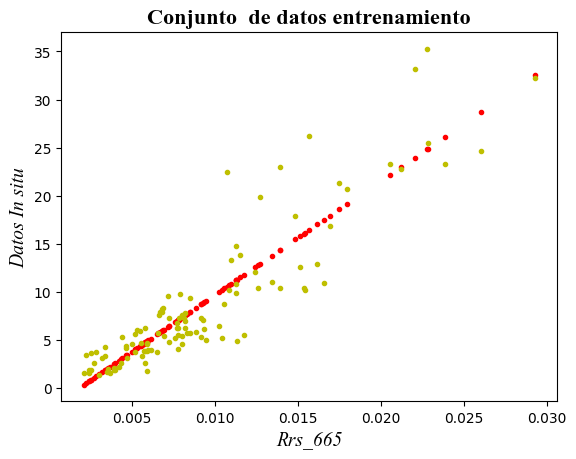

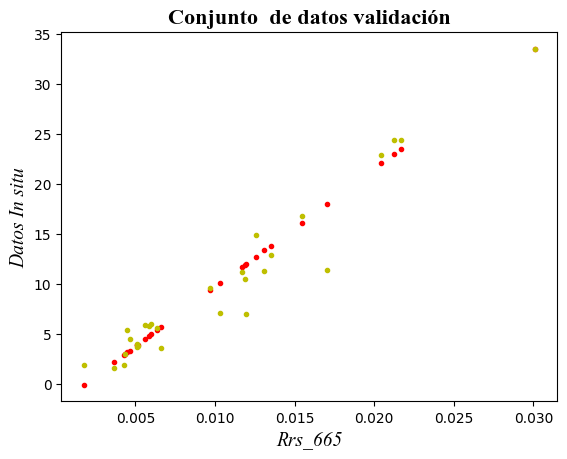

In [46]:
#Creación e inicialización de una instancia del modelo

lin_reg = LinearRegression()

#Modelo a partir de la regresión en el TRAIN
lin_reg.fit(x_reshaped, y.values)

#Coeficiente de la línea recta
b = lin_reg.intercept_ #Intercepto

m = str(lin_reg.coef_) #Pendiente
m = float(m.replace("[", "").replace("]",""))  # Elimina elementos no deseados en el string

#Realizar predicciones
y_pred_train_lin = lin_reg.predict(x_reshaped)
y_pred_test_lin = lin_reg.predict(x_test.values.reshape(-1,1))

#Métricas de rendimiento

#Train
r2_train_lin = r2_score(y, y_pred_train_lin)
mse_train_lin = mean_squared_error(y, y_pred_train_lin)
mape_train_lin = mean_absolute_percentage_error(y, y_pred_train_lin)*100
#Test
r2_test_lin = r2_score(y_test, y_pred_test_lin)
mse_test_lin = mean_squared_error(y_test, y_pred_test_lin)
mape_test_lin = mean_absolute_percentage_error(y_test, y_pred_test_lin)*100

print(f'La funcion lineal es: y = {m} x + {b}')
print('Training')
print('                        R2 --> ', r2_train_lin.round(3) , "   ||| 1 es ideal, 0 es ninguna correlacion")
print('                       MSE --> ', mse_train_lin.round(3), "  ||| Mas cercana a 0 es mejor")
print('                      MAPE --> ', mape_train_lin.round(3), "   ||| menor a 30 es lo mejor")
print('-----'*20)
print('Test')
print('                        R2 --> ', r2_test_lin.round(3) , "   ||| 1 es ideal, 0 es ninguna correlacion")
print('                       MSE --> ', mse_test_lin.round(3), "  ||| Mas cercana a 0 es mejor")
print('                      MAPE --> ', mape_test_lin.round(3), "   ||| menor a 30 es lo mejor")

#Validación cruzada
print('*****'*20)
print('Validación cruzada') #consulte los resultados en el .txt generado al finalizar
validacion_cruzada(lin_reg)

#Gráfica train
plt.plot(x, y_pred_train_lin, "r.")
plt.plot(x, y, "y.")

plt.xlabel(valor_para_X, fontdict={'family': 'Times New Roman', 'size': 14, 'style': 'italic'})
plt.ylabel("Datos In situ", fontdict={'family': 'Times New Roman', 'size': 14, 'style': 'italic'}) 
plt.title(f'Conjunto  de datos entrenamiento', fontname='Times New Roman', fontsize=16, fontweight='bold')

plt.show()

#Gráfica test
plt.plot(x_test, y_pred_test_lin, "r.")
plt.plot(x_test, y_test, "y.")

plt.xlabel(valor_para_X, fontdict={'family': 'Times New Roman', 'size': 14, 'style': 'italic'})
plt.ylabel("Datos In situ", fontdict={'family': 'Times New Roman', 'size': 14, 'style': 'italic'}) 
plt.title(f'Conjunto  de datos validación', fontname='Times New Roman', fontsize=16, fontweight='bold')

plt.show()

### Support Vector Machine (Regression)

In [47]:
from sklearn.svm import SVR

#Ajuste de hipér-parámetros (GRID-SEARCH) 

#Creación e inicialización de una instancia del modelo
svr = SVR()

#Definición de la grilla
param_grid_SVR = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2, 1],
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': ['scale', 'auto']
}
#Diccionario para guardar los mejores parámetros según la métrica de rendimiento (r2, mse, mape)
best_params_SVR = {}

#Búsqueda de rejilla con validación cruzada, por cada estimador de desempeño (r2, mse, mape)
for metric_name, metric_scoring in scoring_gs.items():

    #Configuración de la función GridSearchCV, con validación cruzada definida previamente
    grid_search_SVR = GridSearchCV(svr, param_grid_SVR, cv=k_fold_gs, scoring=metric_scoring)
    grid_search_SVR.fit(x_reshaped, y.values)

    #Se guarda en el diccionario creado previamente
    best_params_SVR[metric_name] = grid_search_SVR.best_params_

#Visualización de los mejores hiper-parámetros por cada estimador de desempeño (r2, mse, mape)
for metric_name, params in best_params_SVR.items():
    print(f'Mejores hiperparámetros para {metric_name}: {params}')



Training
                        R2 -->  0.809    ||| 1 es ideal, 0 es ninguna correlacion
                       MSE -->  10.177   ||| Mas cercana a 0 es mejor
                      MAPE -->  28.668    ||| menor a 30 es lo mejor
----------------------------------------------------------------------------------------------------
Test
                        R2 -->  0.906    ||| 1 es ideal, 0 es ninguna correlacion
                       MSE -->  5.919   ||| Mas cercana a 0 es mejor
                      MAPE -->  21.997    ||| menor a 30 es lo mejor
****************************************************************************************************
Validación cruzada


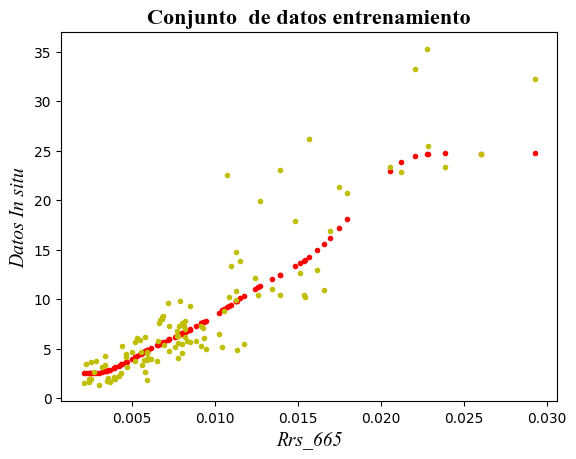

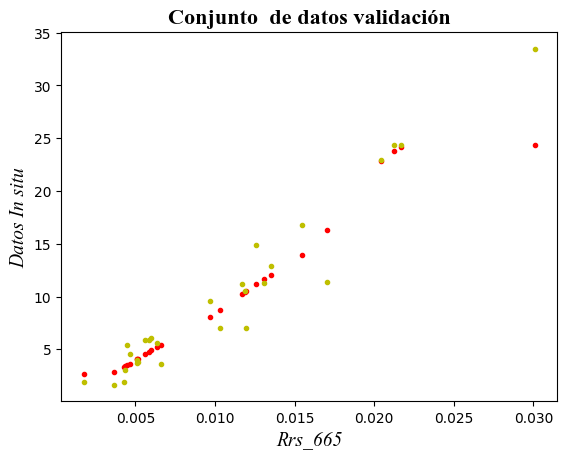

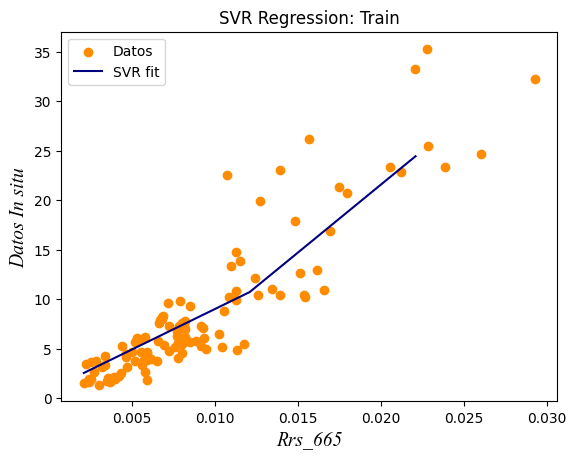

In [30]:
#Train-test y Cross-validate del modelo con los mejores hiper-parámetros

#Diccionarios con los mejores parámetros según la métrica de desempeño
best_params_SVR_r2  = best_params_SVR['r2']
best_params_SVR_mse  = best_params_SVR['mse']
best_params_SVR_mape  = best_params_SVR['mape']

#Elección del diccionario
best_params_SVR_selection = best_params_SVR_r2

#Creación e inicialización de una instancia del modelo ajustado
svr_reg = SVR(**best_params_SVR_selection)#En este caso con los mejores hiper-parámetros de r2. Seleccione según sus necesidades

#Modelo a partir de la regresión en el TRAIN
svr_reg.fit(x_reshaped, y.values)

#Realizar predicciones
y_pred_train_svr = svr_reg.predict(x_reshaped)
y_pred_test_svr = svr_reg.predict(x_test.values.reshape(-1,1))

#Métricas de rendimiento

#Train
r2_train_svr = r2_score(y, y_pred_train_svr)
mse_train_svr = mean_squared_error(y, y_pred_train_svr)
mape_train_svr = mean_absolute_percentage_error(y, y_pred_train_svr)*100
#Test
r2_test_svr = r2_score(y_test, y_pred_test_svr)
mse_test_svr = mean_squared_error(y_test, y_pred_test_svr)
mape_test_svr = mean_absolute_percentage_error(y_test, y_pred_test_svr)*100

print('Training')
print('                        R2 --> ', r2_train_svr.round(3) , "   ||| 1 es ideal, 0 es ninguna correlacion")
print('                       MSE --> ', mse_train_svr.round(3), "  ||| Mas cercana a 0 es mejor")
print('                      MAPE --> ', mape_train_svr.round(3), "   ||| menor a 30 es lo mejor")
print('-----'*20)
print('Test')
print('                        R2 --> ', r2_test_svr.round(3) , "   ||| 1 es ideal, 0 es ninguna correlacion")
print('                       MSE --> ', mse_test_svr.round(3), "  ||| Mas cercana a 0 es mejor")
print('                      MAPE --> ', mape_test_svr.round(3), "   ||| menor a 30 es lo mejor")

#Validación cruzada
print('*****'*20)
print('Validación cruzada') #consulte los resultados en el .txt generado
validacion_cruzada(svr_reg)

#Gráfica train
plt.plot(x, y_pred_train_svr, "r.")
plt.plot(x, y, "y.")

plt.xlabel(valor_para_X, fontdict={'family': 'Times New Roman', 'size': 14, 'style': 'italic'})
plt.ylabel("Datos In situ", fontdict={'family': 'Times New Roman', 'size': 14, 'style': 'italic'}) 
plt.title(f'Conjunto  de datos entrenamiento', fontname='Times New Roman', fontsize=16, fontweight='bold')

plt.show()

#Gráfica test
plt.plot(x_test, y_pred_test_svr, "r.")
plt.plot(x_test, y_test, "y.")

plt.xlabel(valor_para_X, fontdict={'family': 'Times New Roman', 'size': 14, 'style': 'italic'})
plt.ylabel("Datos In situ", fontdict={'family': 'Times New Roman', 'size': 14, 'style': 'italic'}) 
plt.title(f'Conjunto  de datos validación', fontname='Times New Roman', fontsize=16, fontweight='bold')

plt.show()

#Línea de tendencia en la predicción
X_grid = np.arange(min(x), max(x), 0.01)  # Para tener una línea más suave
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(x, y, color='darkorange', label='Datos')
plt.plot(X_grid, svr_reg.predict(X_grid), color='navy', label='SVR fit')
plt.xlabel(valor_para_X, fontdict={'family': 'Times New Roman', 'size': 14, 'style': 'italic'})
plt.ylabel("Datos In situ", fontdict={'family': 'Times New Roman', 'size': 14, 'style': 'italic'}) 
plt.title('SVR Regression: Train')
plt.legend()
plt.show()

### Decision Tree

In [31]:
from sklearn.tree import DecisionTreeRegressor

#Ajuste de hipér-parámetros (GRID-SEARCH)

#Creación e inicialización de una instancia del modelo
tree = DecisionTreeRegressor()

#Definición de la grilla

param_grid_tree = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': [None, 3, 10, 20, 50],
    'min_samples_split': [2, 5, 10, 20],
}
#Diccionario para guardar los mejores parámetros según la métrica de rendimiento (r2, mse, mape)
best_params_tree = {}

#Búsqueda de rejilla con validación cruzada, por cada estimador de desempeño (r2, mse, mape)
for metric_name, metric_scoring in scoring_gs.items():

    #Configuración de la función GridSearchCV, con validación cruzada definida previamente
    grid_search_tree = GridSearchCV(tree, param_grid_tree, cv=k_fold_gs, scoring=metric_scoring)
    grid_search_tree.fit(x_reshaped, y.values)

    #Se guarda en el diccionario creado previamente
    best_params_tree[metric_name] = grid_search_tree.best_params_

#Visualización de los mejores hiper-parámetros por cada estimador de desempeño (r2, mse, mape)
for metric_name, params in best_params_tree.items():
    print(f'Mejores hiperparámetros para {metric_name}: {params}')


Mejores hiperparámetros para r2: {'criterion': 'poisson', 'max_depth': 3, 'min_samples_split': 10}
Mejores hiperparámetros para mse: {'criterion': 'poisson', 'max_depth': 3, 'min_samples_split': 10}
Mejores hiperparámetros para mape: {'criterion': 'absolute_error', 'max_depth': 3, 'min_samples_split': 10}


Training
                        R2 -->  0.866    ||| 1 es ideal, 0 es ninguna correlacion
                       MSE -->  7.152   ||| Mas cercana a 0 es mejor
                      MAPE -->  23.811    ||| menor a 30 es lo mejor
----------------------------------------------------------------------------------------------------
Test
                        R2 -->  0.91    ||| 1 es ideal, 0 es ninguna correlacion
                       MSE -->  5.663   ||| Mas cercana a 0 es mejor
                      MAPE -->  24.402    ||| menor a 30 es lo mejor
****************************************************************************************************
Validación cruzada


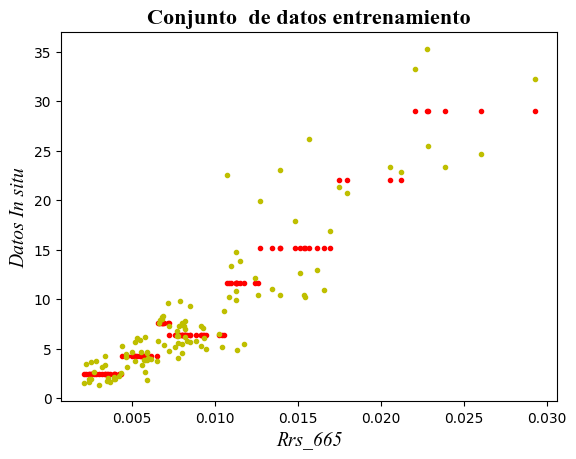

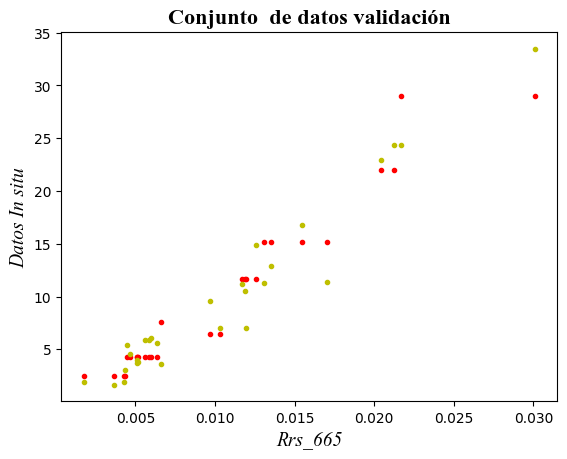

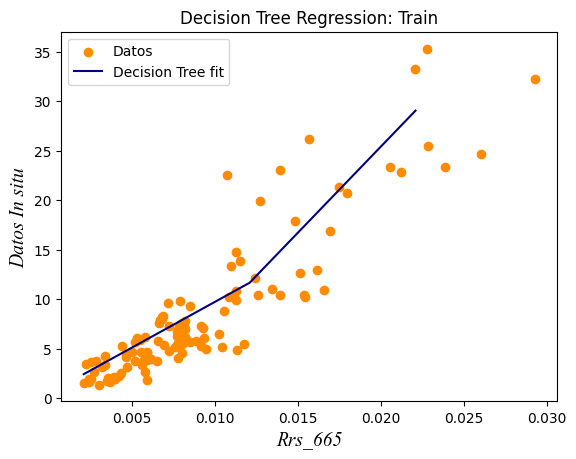

In [32]:

#Train-test y Cross-validate del modelo con los mejores hiper-parámetros

#Diccionarios con los mejores parámetros según la métrica de desempeño
best_params_tree_r2  = best_params_tree['r2']
best_params_tree_mse  = best_params_tree['mse']
best_params_tree_mape  = best_params_tree['mape']

#Elección del diccionario
best_params_tree_selection = best_params_tree_r2

#Creación e inicialización de una instancia del modelo ajustado
tree_reg = DecisionTreeRegressor(**best_params_tree_selection)#En este caso con los mejores hiper-parámetros de r2. Seleccione según sus necesidades

#Modelo a partir de la regresión en el TRAIN
tree_reg.fit(x_reshaped, y.values)

#Realizar predicciones
y_pred_train_tree = tree_reg.predict(x_reshaped)
y_pred_test_tree = tree_reg.predict(x_test.values.reshape(-1,1))

#Métricas de rendimiento
#Train
r2_train_tree = r2_score(y, y_pred_train_tree)
mse_train_tree = mean_squared_error(y, y_pred_train_tree)
mape_train_tree = mean_absolute_percentage_error(y, y_pred_train_tree)*100
#Test
r2_test_tree = r2_score(y_test, y_pred_test_tree)
mse_test_tree = mean_squared_error(y_test, y_pred_test_tree)
mape_test_tree = mean_absolute_percentage_error(y_test, y_pred_test_tree)*100

print('Training')
print('                        R2 --> ', r2_train_tree.round(3) , "   ||| 1 es ideal, 0 es ninguna correlacion")
print('                       MSE --> ', mse_train_tree.round(3), "  ||| Mas cercana a 0 es mejor")
print('                      MAPE --> ', mape_train_tree.round(3), "   ||| menor a 30 es lo mejor")
print('-----'*20)
print('Test')
print('                        R2 --> ', r2_test_tree.round(3) , "   ||| 1 es ideal, 0 es ninguna correlacion")
print('                       MSE --> ', mse_test_tree.round(3), "  ||| Mas cercana a 0 es mejor")
print('                      MAPE --> ', mape_test_tree.round(3), "   ||| menor a 30 es lo mejor")

#Validación cruzada
print('*****'*20)
print('Validación cruzada') #consulte los resultados en el .txt generado
validacion_cruzada(tree_reg)

#Gráfica train
plt.plot(x, y_pred_train_tree, "r.")
plt.plot(x, y, "y.")

plt.xlabel(valor_para_X, fontdict={'family': 'Times New Roman', 'size': 14, 'style': 'italic'})
plt.ylabel("Datos In situ", fontdict={'family': 'Times New Roman', 'size': 14, 'style': 'italic'}) 
plt.title(f'Conjunto  de datos entrenamiento', fontname='Times New Roman', fontsize=16, fontweight='bold')

plt.show()

#Gráfica test
plt.plot(x_test, y_pred_test_tree, "r.")
plt.plot(x_test, y_test, "y.")

plt.xlabel(valor_para_X, fontdict={'family': 'Times New Roman', 'size': 14, 'style': 'italic'})
plt.ylabel("Datos In situ", fontdict={'family': 'Times New Roman', 'size': 14, 'style': 'italic'}) 
plt.title(f'Conjunto  de datos validación', fontname='Times New Roman', fontsize=16, fontweight='bold')

plt.show()

#otra gráfica
X_grid = np.arange(min(x), max(x), 0.01)  # Para tener una línea más suave
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(x, y, color='darkorange', label='Datos')
plt.plot(X_grid, tree_reg.predict(X_grid), color='navy', label='Decision Tree fit')
plt.xlabel(valor_para_X, fontdict={'family': 'Times New Roman', 'size': 14, 'style': 'italic'})
plt.ylabel("Datos In situ", fontdict={'family': 'Times New Roman', 'size': 14, 'style': 'italic'}) 
plt.title('Decision Tree Regression: Train')
plt.legend()
plt.show()

### Random Forest

In [33]:
from sklearn.ensemble import RandomForestRegressor

#Ajuste de hipér-parámetros (GRID-SEARCH)

#Creación e inicialización de una instancia del modelo
forest = RandomForestRegressor()

#Definición de la grilla
param_grid_forest = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'n_estimators': [10, 50, 100, 200, 500],
    'max_depth': [None, 3, 5, 10, 20, 50],
}
#Diccionario para guardar los mejores parámetros según la métrica de rendimiento (r2, mse, mape)
best_params_forest = {}

#Búsqueda de rejilla con validación cruzada, por cada estimador de desempeño (r2, mse, mape)
for metric_name, metric_scoring in scoring_gs.items():

    #Configuración de la función GridSearchCV, con validación cruzada definida previamente
    grid_search_forest = GridSearchCV(forest, param_grid_forest, cv=k_fold_gs, scoring=metric_scoring)
    grid_search_forest.fit(x_reshaped, y.values)

    #Se guarda en el diccionario creado previamente
    best_params_forest[metric_name] = grid_search_forest.best_params_

#Visualización de los mejores hiper-parámetros por cada estimador de desempeño (r2, mse, mape)
for metric_name, params in best_params_forest.items():
    print(f'Mejores hiperparámetros para {metric_name}: {params}')

#Note que el modelo, entre iteracioens en la ejecución del código, puede obtener distintos conjuntos de mejores hiperparámetros
#Esto debido a que random state no se encuentra definido antes de la búsqueda de rejilla

Mejores hiperparámetros para r2: {'criterion': 'absolute_error', 'max_depth': 3, 'n_estimators': 50}
Mejores hiperparámetros para mse: {'criterion': 'absolute_error', 'max_depth': 3, 'n_estimators': 10}
Mejores hiperparámetros para mape: {'criterion': 'absolute_error', 'max_depth': 3, 'n_estimators': 10}


{'criterion': 'absolute_error', 'max_depth': 3, 'n_estimators': 50, 'random_state': 13}
Training
                        R2 -->  0.882    ||| 1 es ideal, 0 es ninguna correlacion
                       MSE -->  6.268   ||| Mas cercana a 0 es mejor
                      MAPE -->  22.54    ||| menor a 30 es lo mejor
----------------------------------------------------------------------------------------------------
Test
                        R2 -->  0.922    ||| 1 es ideal, 0 es ninguna correlacion
                       MSE -->  4.876   ||| Mas cercana a 0 es mejor
                      MAPE -->  20.723    ||| menor a 30 es lo mejor
****************************************************************************************************
Validación cruzada


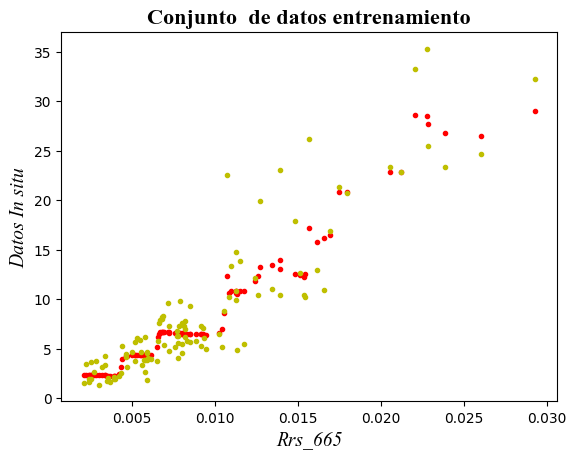

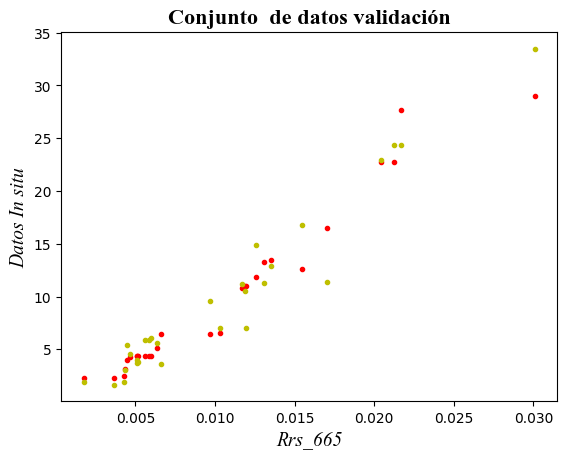

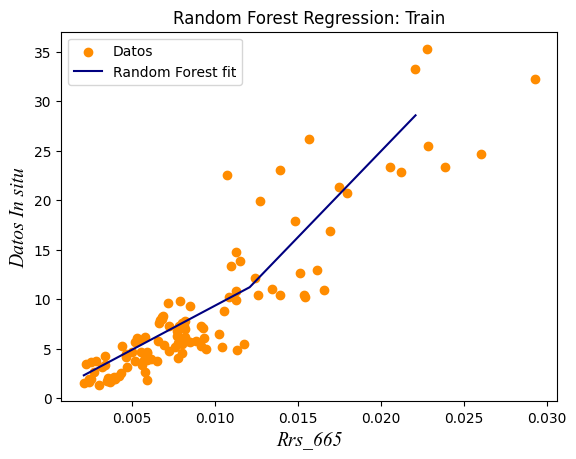

In [34]:

#Train-test y Cross-validate del modelo con los mejores hiper-parámetros

#Diccionarios con los mejores parámetros según la métrica de desempeño
best_params_forest_r2  = best_params_forest['r2']
best_params_forest_mse  = best_params_forest['mse']
best_params_forest_mape  = best_params_forest['mape']

#Elección del diccionario
best_params_forest_selection = best_params_forest_r2
best_params_forest_selection['random_state'] = 13
print(best_params_forest_selection)

#Creación e inicialización de una instancia del modelo ajustado
forest_reg = RandomForestRegressor(**best_params_forest_selection)#En este caso con los mejores hiper-parámetros de r2. Seleccione según sus necesidades

#Modelo a partir de la regresión en el TRAIN
forest_reg.fit(x_reshaped, y.values)

#Realizar predicciones
y_pred_train_forest = forest_reg.predict(x_reshaped)
y_pred_test_forest = forest_reg.predict(x_test.values.reshape(-1,1))

#Métricas de rendimiento
#Train
r2_train_forest = r2_score(y, y_pred_train_forest)
mse_train_forest = mean_squared_error(y, y_pred_train_forest)
mape_train_forest = mean_absolute_percentage_error(y, y_pred_train_forest)*100
#Test
r2_test_forest = r2_score(y_test, y_pred_test_forest)
mse_test_forest = mean_squared_error(y_test, y_pred_test_forest)
mape_test_forest = mean_absolute_percentage_error(y_test, y_pred_test_forest)*100

print('Training')
print('                        R2 --> ', r2_train_forest.round(3) , "   ||| 1 es ideal, 0 es ninguna correlacion")
print('                       MSE --> ', mse_train_forest.round(3), "  ||| Mas cercana a 0 es mejor")
print('                      MAPE --> ', mape_train_forest.round(3), "   ||| menor a 30 es lo mejor")
print('-----'*20)
print('Test')
print('                        R2 --> ', r2_test_forest.round(3) , "   ||| 1 es ideal, 0 es ninguna correlacion")
print('                       MSE --> ', mse_test_forest.round(3), "  ||| Mas cercana a 0 es mejor")
print('                      MAPE --> ', mape_test_forest.round(3), "   ||| menor a 30 es lo mejor")

#Validación cruzada
print('*****'*20)
print('Validación cruzada') #consulte los resultados en el .txt generado
validacion_cruzada(forest_reg)

#Gráfica train
plt.plot(x, y_pred_train_forest, "r.")
plt.plot(x, y, "y.")

plt.xlabel(valor_para_X, fontdict={'family': 'Times New Roman', 'size': 14, 'style': 'italic'})
plt.ylabel("Datos In situ", fontdict={'family': 'Times New Roman', 'size': 14, 'style': 'italic'}) 
plt.title(f'Conjunto  de datos entrenamiento', fontname='Times New Roman', fontsize=16, fontweight='bold')

plt.show()

#Gráfica test
plt.plot(x_test, y_pred_test_forest, "r.")
plt.plot(x_test, y_test, "y.")

plt.xlabel(valor_para_X, fontdict={'family': 'Times New Roman', 'size': 14, 'style': 'italic'})
plt.ylabel("Datos In situ", fontdict={'family': 'Times New Roman', 'size': 14, 'style': 'italic'}) 
plt.title(f'Conjunto  de datos validación', fontname='Times New Roman', fontsize=16, fontweight='bold')

plt.show()

#otra gráfica
X_grid = np.arange(min(x), max(x), 0.01)  # Para tener una línea más suave
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(x, y, color='darkorange', label='Datos')
plt.plot(X_grid, forest_reg.predict(X_grid), color='navy', label='Random Forest fit')
plt.xlabel(valor_para_X, fontdict={'family': 'Times New Roman', 'size': 14, 'style': 'italic'})
plt.ylabel("Datos In situ", fontdict={'family': 'Times New Roman', 'size': 14, 'style': 'italic'}) 
plt.title('Random Forest Regression: Train')
plt.legend()
plt.show()

### Lectura de datos

In [35]:
#variable global para guardar los resultados
RESULTS = []

RESULTS.append(f'Dataset: {dataset}')
RESULTS.append(f'Indice: {valor_para_X}')
RESULTS.append(f'DF:{DF}')
RESULTS.append(f'K_fold_gs: {n_splits_gs}')
RESULTS.append(f'K_fold: {n_splits}')

#regresión lineal
RESULTS.append(f'Regresión lineal')
RESULTS.append(f'La funcion lineal es: y = {m} x + {b}')
RESULTS.append('Training')
RESULTS.append(f'                        R2 -->  {r2_train_lin.round(3)}    ||| 1 es ideal, 0 es ninguna correlacion')
RESULTS.append(f'                       MSE -->  {mse_train_lin.round(3)}  ||| Mas cercana a 0 es mejor')
RESULTS.append(f'                      MAPE -->  {mape_train_lin.round(3)}   ||| menor a 30 es lo mejor')
RESULTS.append('-----'*20)
RESULTS.append('Test')
RESULTS.append(f'                        R2 -->  {r2_test_lin.round(3)}    ||| 1 es ideal, 0 es ninguna correlacion')
RESULTS.append(f'                       MSE -->  {mse_test_lin.round(3)}  ||| Mas cercana a 0 es mejor')
RESULTS.append(f'                      MAPE -->  {mape_test_lin.round(3)}   ||| menor a 30 es lo mejor')
RESULTS.append('*****'*20)
RESULTS.append('Validación cruzada')
RESULTS.append(validacion_cruzada(lin_reg))

#SVM
RESULTS.append(f'SVM')
RESULTS.append(f'Mejores hiperpárametros{best_params_SVR_selection}')
RESULTS.append('Training')
RESULTS.append(f'                        R2 -->  {r2_train_svr.round(3)}    ||| 1 es ideal, 0 es ninguna correlacion')
RESULTS.append(f'                       MSE -->  {mse_train_svr.round(3)}  ||| Mas cercana a 0 es mejor')
RESULTS.append(f'                      MAPE -->  {mape_train_svr.round(3)}   ||| menor a 30 es lo mejor')
RESULTS.append('-----'*20)
RESULTS.append('Test')
RESULTS.append(f'                        R2 -->  {r2_test_svr.round(3)}    ||| 1 es ideal, 0 es ninguna correlacion')
RESULTS.append(f'                       MSE -->  {mse_test_svr.round(3)}  ||| Mas cercana a 0 es mejor')
RESULTS.append(f'                      MAPE -->  {mape_test_svr.round(3)}   ||| menor a 30 es lo mejor')
RESULTS.append('-----'*20)
RESULTS.append('Validación cruzada')
RESULTS.append(validacion_cruzada(svr_reg))

#DT
RESULTS.append(f'Decision Tree')
RESULTS.append(f'Mejores hiperpárametros{best_params_tree_selection}')
RESULTS.append('Training')
RESULTS.append(f'                        R2 -->  {r2_train_tree.round(3)}    ||| 1 es ideal, 0 es ninguna correlacion')
RESULTS.append(f'                       MSE -->  {mse_train_tree.round(3)}  ||| Mas cercana a 0 es mejor')
RESULTS.append(f'                      MAPE -->  {mape_train_tree.round(3)}   ||| menor a 30 es lo mejor')
RESULTS.append('-----'*20)
RESULTS.append('Test')
RESULTS.append(f'                        R2 -->  {r2_test_tree.round(3)}    ||| 1 es ideal, 0 es ninguna correlacion')
RESULTS.append(f'                       MSE -->  {mse_test_tree.round(3)}  ||| Mas cercana a 0 es mejor')
RESULTS.append(f'                      MAPE -->  {mape_test_tree.round(3)}   ||| menor a 30 es lo mejor')
RESULTS.append('*****'*20)
RESULTS.append('Validación cruzada')
RESULTS.append(validacion_cruzada(tree_reg))

#RF
RESULTS.append(f'Random Forest')
RESULTS.append(f'Mejores hiperpárametros{best_params_forest_selection}')
RESULTS.append('Training')
RESULTS.append(f'                        R2 -->  {r2_train_forest.round(3)}    ||| 1 es ideal, 0 es ninguna correlacion')
RESULTS.append(f'                       MSE -->  {mse_train_forest.round(3)}  ||| Mas cercana a 0 es mejor')
RESULTS.append(f'                      MAPE -->  {mape_train_forest.round(3)}   ||| menor a 30 es lo mejor')
RESULTS.append('-----'*20)
RESULTS.append('Test')
RESULTS.append(f'                        R2 -->  {r2_test_forest.round(3)}    ||| 1 es ideal, 0 es ninguna correlacion')
RESULTS.append(f'                       MSE -->  {mse_test_forest.round(3)}  ||| Mas cercana a 0 es mejor')
RESULTS.append(f'                      MAPE -->  {mape_test_forest.round(3)}   ||| menor a 30 es lo mejor')
RESULTS.append('*****'*20)
RESULTS.append('Validación cruzada')
RESULTS.append(validacion_cruzada(forest_reg))

### Exportación de los resultados

In [36]:
with open(f'TT_RESULTS_{valor_para_X}_{DF}.txt', 'w') as file: #Cambie el nombre del arhivo final según sus necesidades
    for resultado in RESULTS:
        file.write(resultado)
        file.write("\n\n")

### Modelación con algoritmo entrenado

In [37]:
nuevo_df = pd.read_excel("all_data_modeling.xlsx")

#Filtrar los valores permitidos
nuevo_df = nuevo_df[nuevo_df['Rrs_665'] > 0 ]

nuevo_df = nuevo_df[nuevo_df['Rrs_709'] > 0 ]

nuevo_df = nuevo_df[nuevo_df['l2_flags'] <= 1 ]

nuevo_df = nuevo_df.reset_index()

nuevo_df

,index,Fecha,Pixel-X,Pixel-Y,Longitude,Latitude,lon,lat,Rrs_400,Rrs_412,...,Rrs_682,Rrs_709,Rrs_754,Rrs_768,Rrs_779,Rrs_865,Rrs_884,Rrs_1016,l2_flags,NDCI
0,0,2022-11-01,46.5,11.5,-75.547264,10.407240,-75.547264,10.407240,0.007881,0.008205,...,0.009481,0.008376,0.009641,0.009885,0.009437,9.463362e-03,0.009235,0.010523,0,-0.047396
1,1,2022-11-01,48.5,11.5,-75.543739,10.406507,-75.543740,10.406507,0.005697,0.005038,...,0.003556,0.002268,0.001726,0.001778,0.001344,2.735678e-04,-0.000253,0.001212,0,-0.216313
2,2,2022-11-01,46.5,12.5,-75.547813,10.404647,-75.547810,10.404647,0.006639,0.005973,...,0.005405,0.004105,0.003847,0.003823,0.003580,2.829333e-03,0.002629,0.004048,0,-0.137181
3,3,2022-11-01,48.5,12.5,-75.544235,10.403901,-75.544235,10.403901,0.005385,0.004916,...,0.003520,0.002114,0.001502,0.001403,0.001163,-9.993582e-07,-0.000392,0.000575,0,-0.227333
4,4,2022-11-01,49.5,12.5,-75.540710,10.403168,-75.540710,10.403168,0.005898,0.005410,...,0.004156,0.002652,0.001974,0.002130,0.001627,3.928664e-04,-0.000234,0.000316,0,-0.197454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21262,21668,2018-02-26,92.5,53.5,-75.562279,10.277177,-75.562280,10.277177,0.006250,0.006072,...,0.005809,0.004214,0.003589,0.002942,0.003258,2.022689e-03,0.001607,0.001085,0,-0.174978
21263,21669,2018-02-26,94.5,53.5,-75.559502,10.276582,-75.559500,10.276582,0.006145,0.005960,...,0.006240,0.004470,0.003668,0.002885,0.003385,2.040228e-03,0.001441,0.001926,0,-0.162744
21264,21670,2018-02-26,90.5,54.5,-75.568375,10.275761,-75.568375,10.275761,0.006397,0.006342,...,0.006576,0.004437,0.003517,0.002793,0.003078,1.570497e-03,0.000756,0.000427,0,-0.189080
21265,21671,2018-02-26,91.5,54.5,-75.565605,10.275168,-75.565605,10.275168,0.006475,0.005825,...,0.006145,0.004218,0.003520,0.002686,0.003041,1.471205e-03,0.000587,-0.000194,0,-0.174988


In [38]:
x_modeling = nuevo_df['Rrs_665'].values.reshape(-1,1)

#Usamos el mejor modelo para hacer las predicciones
y_modeling = svr_reg.predict(x_modeling)#En este caso se usó SVM. Seleccione según sus necesidades

y_modeling_df = pd.DataFrame(y_modeling, columns=['TT_pred'])

final = nuevo_df[['Fecha', 'Longitude', 'Latitude', 'Rrs_665']].copy()

final['TT_pred'] = y_modeling_df['TT_pred']

final.to_excel('MODELING_TT_SVM.xlsx', index=None)#Cambie el nombre del archivo final según sus necesidades